# Using code from John to generate some data for test

In [48]:
# functions from John Slattery's work

import numpy as np


def linear_ramp(t, t0=0.0, dt=1.0, y0=0.0, dy=1.0, GS_slope = 0.0, GIS_slope=0.0):
    """Linear Ramp Function

    This function describes the piece-wise linear ramp.

    Parameter
    ---------
    t : np.ndarray
        Time variable
    t0 : float
        Start time of the ramp
    dt : float
        Transition length
    y0 : float
        Function value before the transition
    dy : float
        Hight of the transition
    GS_slope : float
        slope before transition - can be positive or negative
    GIS_slope : float
        slope after transition - can be positive or negative

    Return
    ------
    y : np.ndarray
        Function values of the linear transiton
    """
    lt_t0 = t < t0
    gt_t1 = t > t0 + dt
    condlist = [lt_t0,
                ~np.logical_or(lt_t0, gt_t1),
                gt_t1]
    funclist = [lambda t: y0 + GS_slope * (t - t0),
                lambda t: y0 + dy * (t - t0) / dt,
                lambda t: y0 + dy + GIS_slope * (t - t0 - dt)]
    y = np.piecewise(t, condlist, funclist)
    return y


def sample_ar1(n, alpha, sigma=1.0, x0=0):
    """Generate AR(1) noise for evenely sampled series"""
    x = np.zeros(n)
    x[0] = x0 + sigma * np.random.randn()
    sigma_e = np.sqrt(sigma ** 2 * (1 - alpha ** 2))
    for i in range(1, n):
        x[i] = alpha * x[i - 1] + sigma_e * np.random.randn()
    return x


import numpy as np
import pandas as pd


def gen_dummy_DO(length, delta=10.0, t0=800.0, dt=50.0, dy=1.0, GS_slope=5e-4, GIS_slope=-1e-3, tau=1.0, sigma=0.05):
    """
    Generate dummy time series data for demonstration purposes.

    Args:
    length (int): Length of the time series data.
    delta (float): Time step.
    t0 (float): Starting time.
    dt (float): Duration of the transition.
    dy (float): Amplitude of the transition.
    GS_slope (float): Slope of the Gaussian-shaped transition.
    GIS_slope (float): Slope of the Glacial-interglacial-shaped transition.
    causal_strength (float): Strength of the causal link.
    sigma (float): Standard deviation of the noise.
    tau (float): Time constant for the autoregressive process.

    Returns:
    pandas.DataFrame: DataFrame containing dummy time series data.
    """
    alpha = np.exp(-delta / tau)
    # time = np.arange(t0, t0 + length * delta, step=delta, dtype='float')
    time = np.arange(length, step=delta, dtype='float')
    trans = linear_ramp(time, t0=t0, dt=dt, y0=0.0, dy=dy, GS_slope=GS_slope, GIS_slope=GIS_slope)
    noise = sample_ar1(len(time), alpha=alpha, sigma=sigma, x0=0)
    synt_trans = trans + noise

    df = pd.DataFrame({
        'time': time,
        'A': synt_trans,
        'trans': trans
    })

    return df

def gen_linked_data(df, lag=10, causal_strength=0.5, delta=10.0, tau=1.0, sigma=0.05):
    """
    Generate causally linked synthetic data.

    Args:
    df (pandas.DataFrame): DataFrame containing synthetic time series data.
    lag (int): Lag for the causal effect. Positive lag means left shifting the series.
    causal_strength (float): Strength of the causal link.
    delta (float): Time step.
    tau (float): Time constant for the autoregressive process.
    sigma (float): Standard deviation of the noise.


    Returns:
    pandas.DataFrame: DataFrame containing causally linked synthetic data.
    """
    synt_trans = df['trans'].values
    alpha = np.exp(-delta / tau)
    # Shift the series
    if lag > 0:
        left_shifted_synt_trans = np.full_like(synt_trans, np.nan)
        left_shifted_synt_trans[:-lag] = synt_trans[lag:]
    if lag < 0:
        left_shifted_synt_trans = np.full_like(synt_trans, np.nan)
        left_shifted_synt_trans[-lag:] = synt_trans[:lag]
    if lag == 0:
        left_shifted_synt_trans=synt_trans

    # Generate AR(1) noise as the base for the second causally linked dataset
    new_noise = sample_ar1(len(synt_trans), alpha=alpha, sigma=sigma, x0=0)

    # Combine the lagged original series with the new AR(1) series to produce the causally linked series
    causally_linked_synt_trans = new_noise + causal_strength * left_shifted_synt_trans

    df['B'] = causally_linked_synt_trans
    return df.dropna()





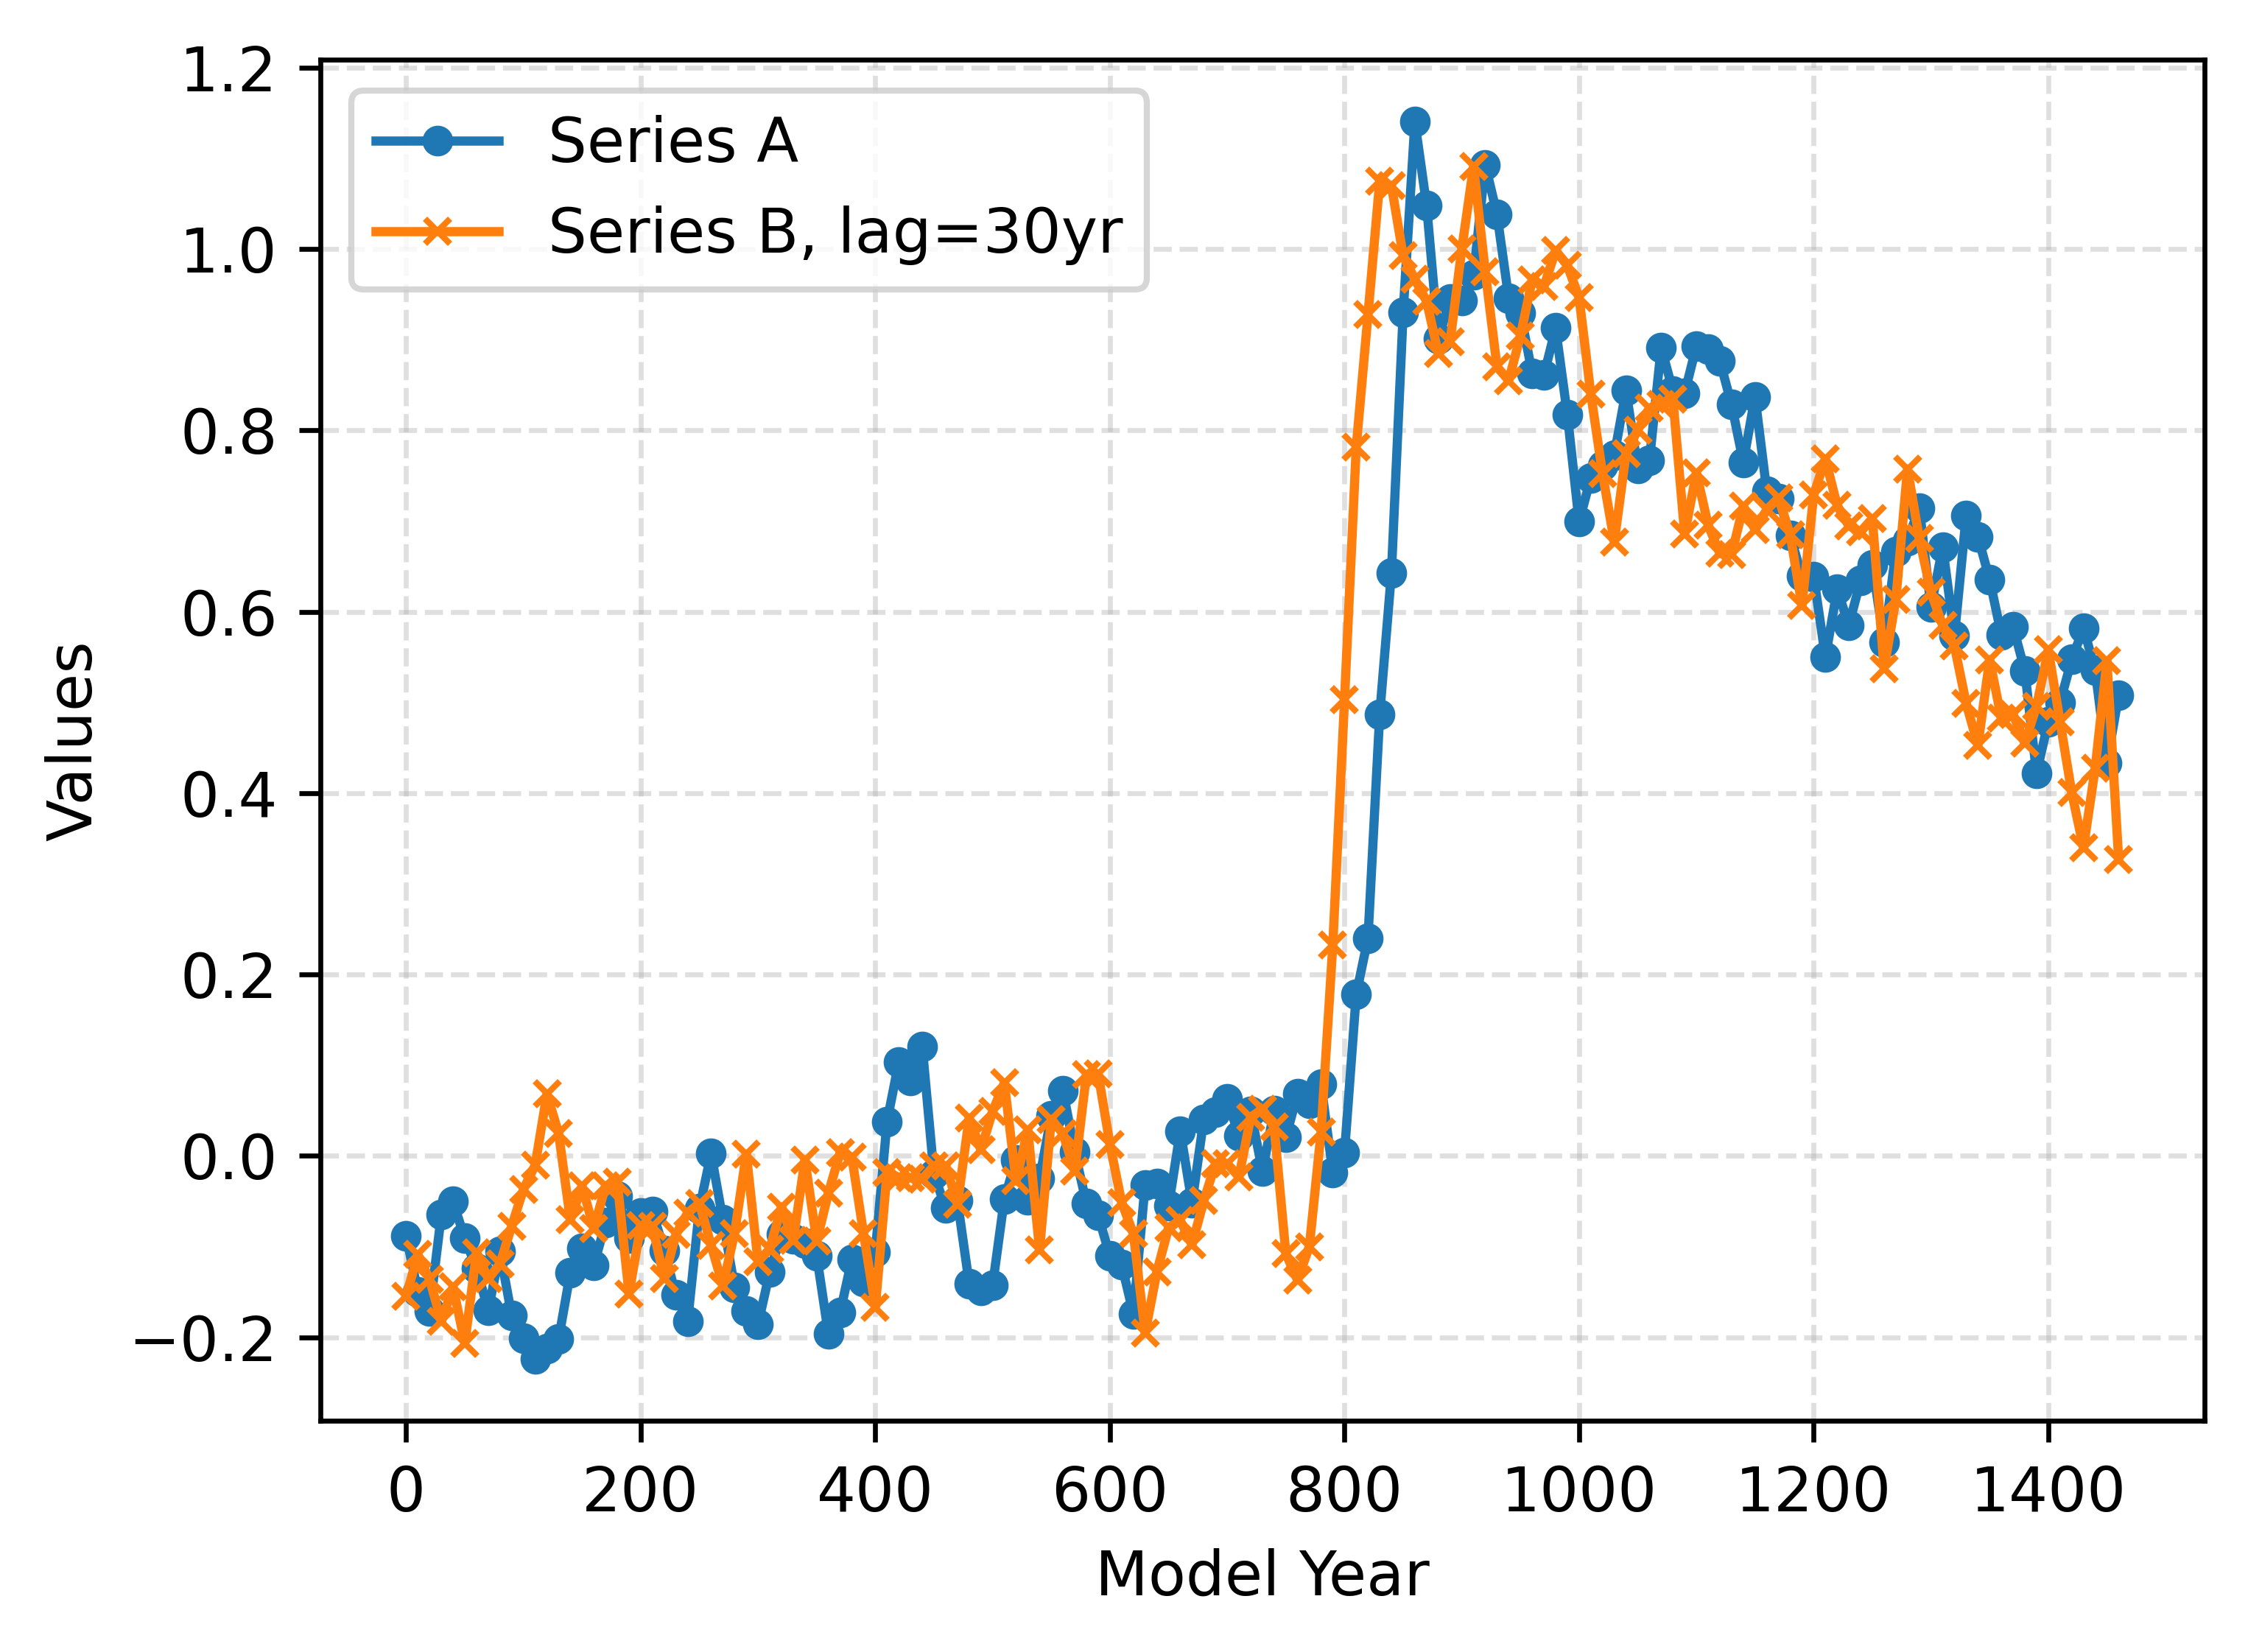

In [68]:
import matplotlib.pyplot as plt

# Generate dummy data
# dummy_warming = gen_dummy_DO(length=1500, delta=10.0, t0=800.0, dt=50.0, dy=2.0, GS_slope=5e-4, GIS_slope=-1e-3, sigma=0.1, tau=1.0)
# dummy_warming

# # # Generate causally linked data with lag=5
# dummy_warming_lagged = gen_linked_data(dummy_warming, causal_strength=1, delta=10.0, lag=3, tau=1.0, sigma=0.1)
# dummy_warming_lagged


lag=3
dummy_data = gen_dummy_DO(length=1500, delta=10.0, t0=800.0, dt=56.32925780771254, dy=1.0, GS_slope=0.00016431508734689263, GIS_slope=-0.0009404944834246113, sigma=0.06633234778696487, tau=13.649751415738818)
dummy_warming_lagged = gen_linked_data(dummy_data, causal_strength=1, delta=10.0, lag=lag, tau=13.649751415738818, sigma=0.06633234778696487)


# Enhance the plot
plt.figure(figsize=(5.5, 4),dpi=600)  # Adjust the figure size
plt.plot(dummy_warming_lagged['time'], dummy_warming_lagged['A'], label='Series A', linestyle='-', marker='o', markersize=4)
plt.plot(dummy_warming_lagged['time'], dummy_warming_lagged['B'], label=f'Series B, lag={lag*10}yr', linestyle='-', marker='x', markersize=4)

# Add grid, title, and labels
plt.grid(True, linestyle='--', alpha=0.4)
# plt.title('Time Series of Dummy Warming Data')
plt.xlabel('Model Year')
plt.ylabel('Values')

# Add legend
plt.legend()

plt.show()


In [70]:
gc_test_single_pair(dummy_warming_lagged['A'].values, dummy_warming_lagged['B'].values,max_lags=10)

(True, False)

In [47]:
from statsmodels.tsa.stattools import grangercausalitytests
import numpy as np
from concurrent.futures import ThreadPoolExecutor, as_completed

def gc_test_single_pair(data_x_col, data_y_col, max_lags=4):
    """
    Perform Granger Causality test for a single pair of time series.
    
    Parameters:
    - data_x_col: 1D NumPy ndarray containing the time series data for x.
    - data_y_col: 1D NumPy ndarray containing the time series data for y.
    - max_lags: int, maximum number of lags to test for.
    
    Returns:
    - Tuple of two booleans: (result_xy, result_yx) indicating the direction of Granger causality for the pair.
    """
    # Drop NaN values from both time series
    valid_idx = ~np.isnan(data_x_col) & ~np.isnan(data_y_col)
    data_x_col_clean = data_x_col[valid_idx]
    data_y_col_clean = data_y_col[valid_idx]

    # Combine the cleaned and cropped data for Granger Causality test
    combined_data = np.column_stack((data_x_col_clean, data_y_col_clean))
    
    # Granger Causality test
    result_xy = grangercausalitytests(combined_data, max_lags, verbose=False)
    result_yx = grangercausalitytests(combined_data[:, [1, 0]], max_lags, verbose=False)
    
    # Simplify result interpretation
    test_result_xy = any(result_xy[lag][0]['ssr_ftest'][1] < 0.05 for lag in range(1, max_lags + 1))
    test_result_yx = any(result_yx[lag][0]['ssr_ftest'][1] < 0.05 for lag in range(1, max_lags + 1))
    
    return test_result_xy, test_result_yx

def gc_test_parallel(data_x, data_y, max_lags=4, num_workers=None):
    """
    Perform Granger Causality tests in parallel for each pair of columns in data_x and data_y.
    
    Parameters:
    - data_x, data_y: 2D NumPy ndarrays containing the time series data.
    - max_lags: int, maximum number of lags to test for.
    - num_workers: int or None, number of worker threads to use. If None, it will use the default.
    
    Returns:
    - List of tuples with the Granger Causality test results for each pair.
    """
    num_series = data_x.shape[1]
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        futures = [executor.submit(gc_test_single_pair, data_x[:, i], data_y[:, i], max_lags) for i in range(num_series)]
        
        results = []
        for future in as_completed(futures):
            result = future.result()
            results.append(result)
    return results


In [44]:
import numpy as np

np.random.seed(0)  # For reproducibility

# Parameters
num_series = 10  # Number of series in each data set
num_points = 150  # Number of points in each time series
max_lags = 4  # Max lags for Granger Causality test

# Generate independent time series for data_x
data_x = np.random.normal(size=(num_points, num_series))

# Generate data_y with some series being lagged versions of data_x (to simulate causality)
data_y = np.empty_like(data_x)

# Let's make series 0 and 1 in data_y lagged versions of series in data_x, adding noise
for i in range(num_series):
    if i < 2:  # First two series have causality
        data_y[:, i] = np.roll(data_x[:, i], shift=1) + np.random.normal(scale=0.1, size=num_points)
    else:  # The rest are independent
        data_y[:, i] = np.random.normal(size=num_points)

# Ensure the first element of lagged series does not use the 'rolled' value
data_y[0, :2] = np.random.normal(size=2)

gc_test_parallel(data_x, data_x, max_lags=max_lags)


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


[(False, False),
 (False, False),
 (False, False),
 (False, False),
 (False, False),
 (False, False),
 (False, False),
 (False, False),
 (False, False),
 (False, False)]

In [83]:
import numpy as np
import pandas as pd
from toolbox import GC_functions as GC  


# Initialize parameters
causal_strengths = np.arange(0.1, 1.1, 0.1)  # From 0.1 to 1.0 in steps of 0.1
lags = range(11)  # From 0 to 10
iterations = 100

causal_results = np.zeros((len(causal_strengths), len(lags)))

# Loop through combinations of causal strengths and lags
for i, strength in enumerate(causal_strengths):
    for j, lag in enumerate(lags):
        results_xy = np.zeros(iterations, dtype=bool)

        data_x = np.ones((150, iterations))*np.nan
        data_y = np.ones((150, iterations))*np.nan

        for k in range(iterations):
            # Generate dummy data and linked data using the DataFrame version
            dummy_data = gen_dummy_DO(length=1500, delta=10.0, t0=800.0, dt=56.32925780771254, dy=1.0, GS_slope=0.00016431508734689263, GIS_slope=-0.0009404944834246113, sigma=0.06633234778696487, tau=13.649751415738818)
            dummy_warming_lagged = gen_linked_data(dummy_data, causal_strength=strength, delta=10.0, lag=lag, tau=13.649751415738818, sigma=0.06633234778696487)

            df_gc = dummy_warming_lagged[['A', 'B']]
            
            df_gc_checked = GC.make_stationary(df_gc,['A', 'B'], test_method='ADF', plot=False)

            data_x[:len(df_gc_checked['A'].values), k] = df_gc_checked['A'].values
            data_y[:len(df_gc_checked['B'].values), k] = df_gc_checked['B'].values

        gc_results = gc_test_parallel(data_x, data_y, max_lags=19,num_workers=iterations)
        true_in_first_pos_percentage = sum(result[0] for result in gc_results) / iterations
        false_in_second_pos_percentage = sum(not result[1] for result in gc_results) / iterations
        
        if true_in_first_pos_percentage > 0.95 and false_in_second_pos_percentage > 0.05:
            causal_results[i, j] = 1
        else:
            causal_results[i, j] = 0


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
d:\Users\User\anaconda3\envs\pz_venv_cau

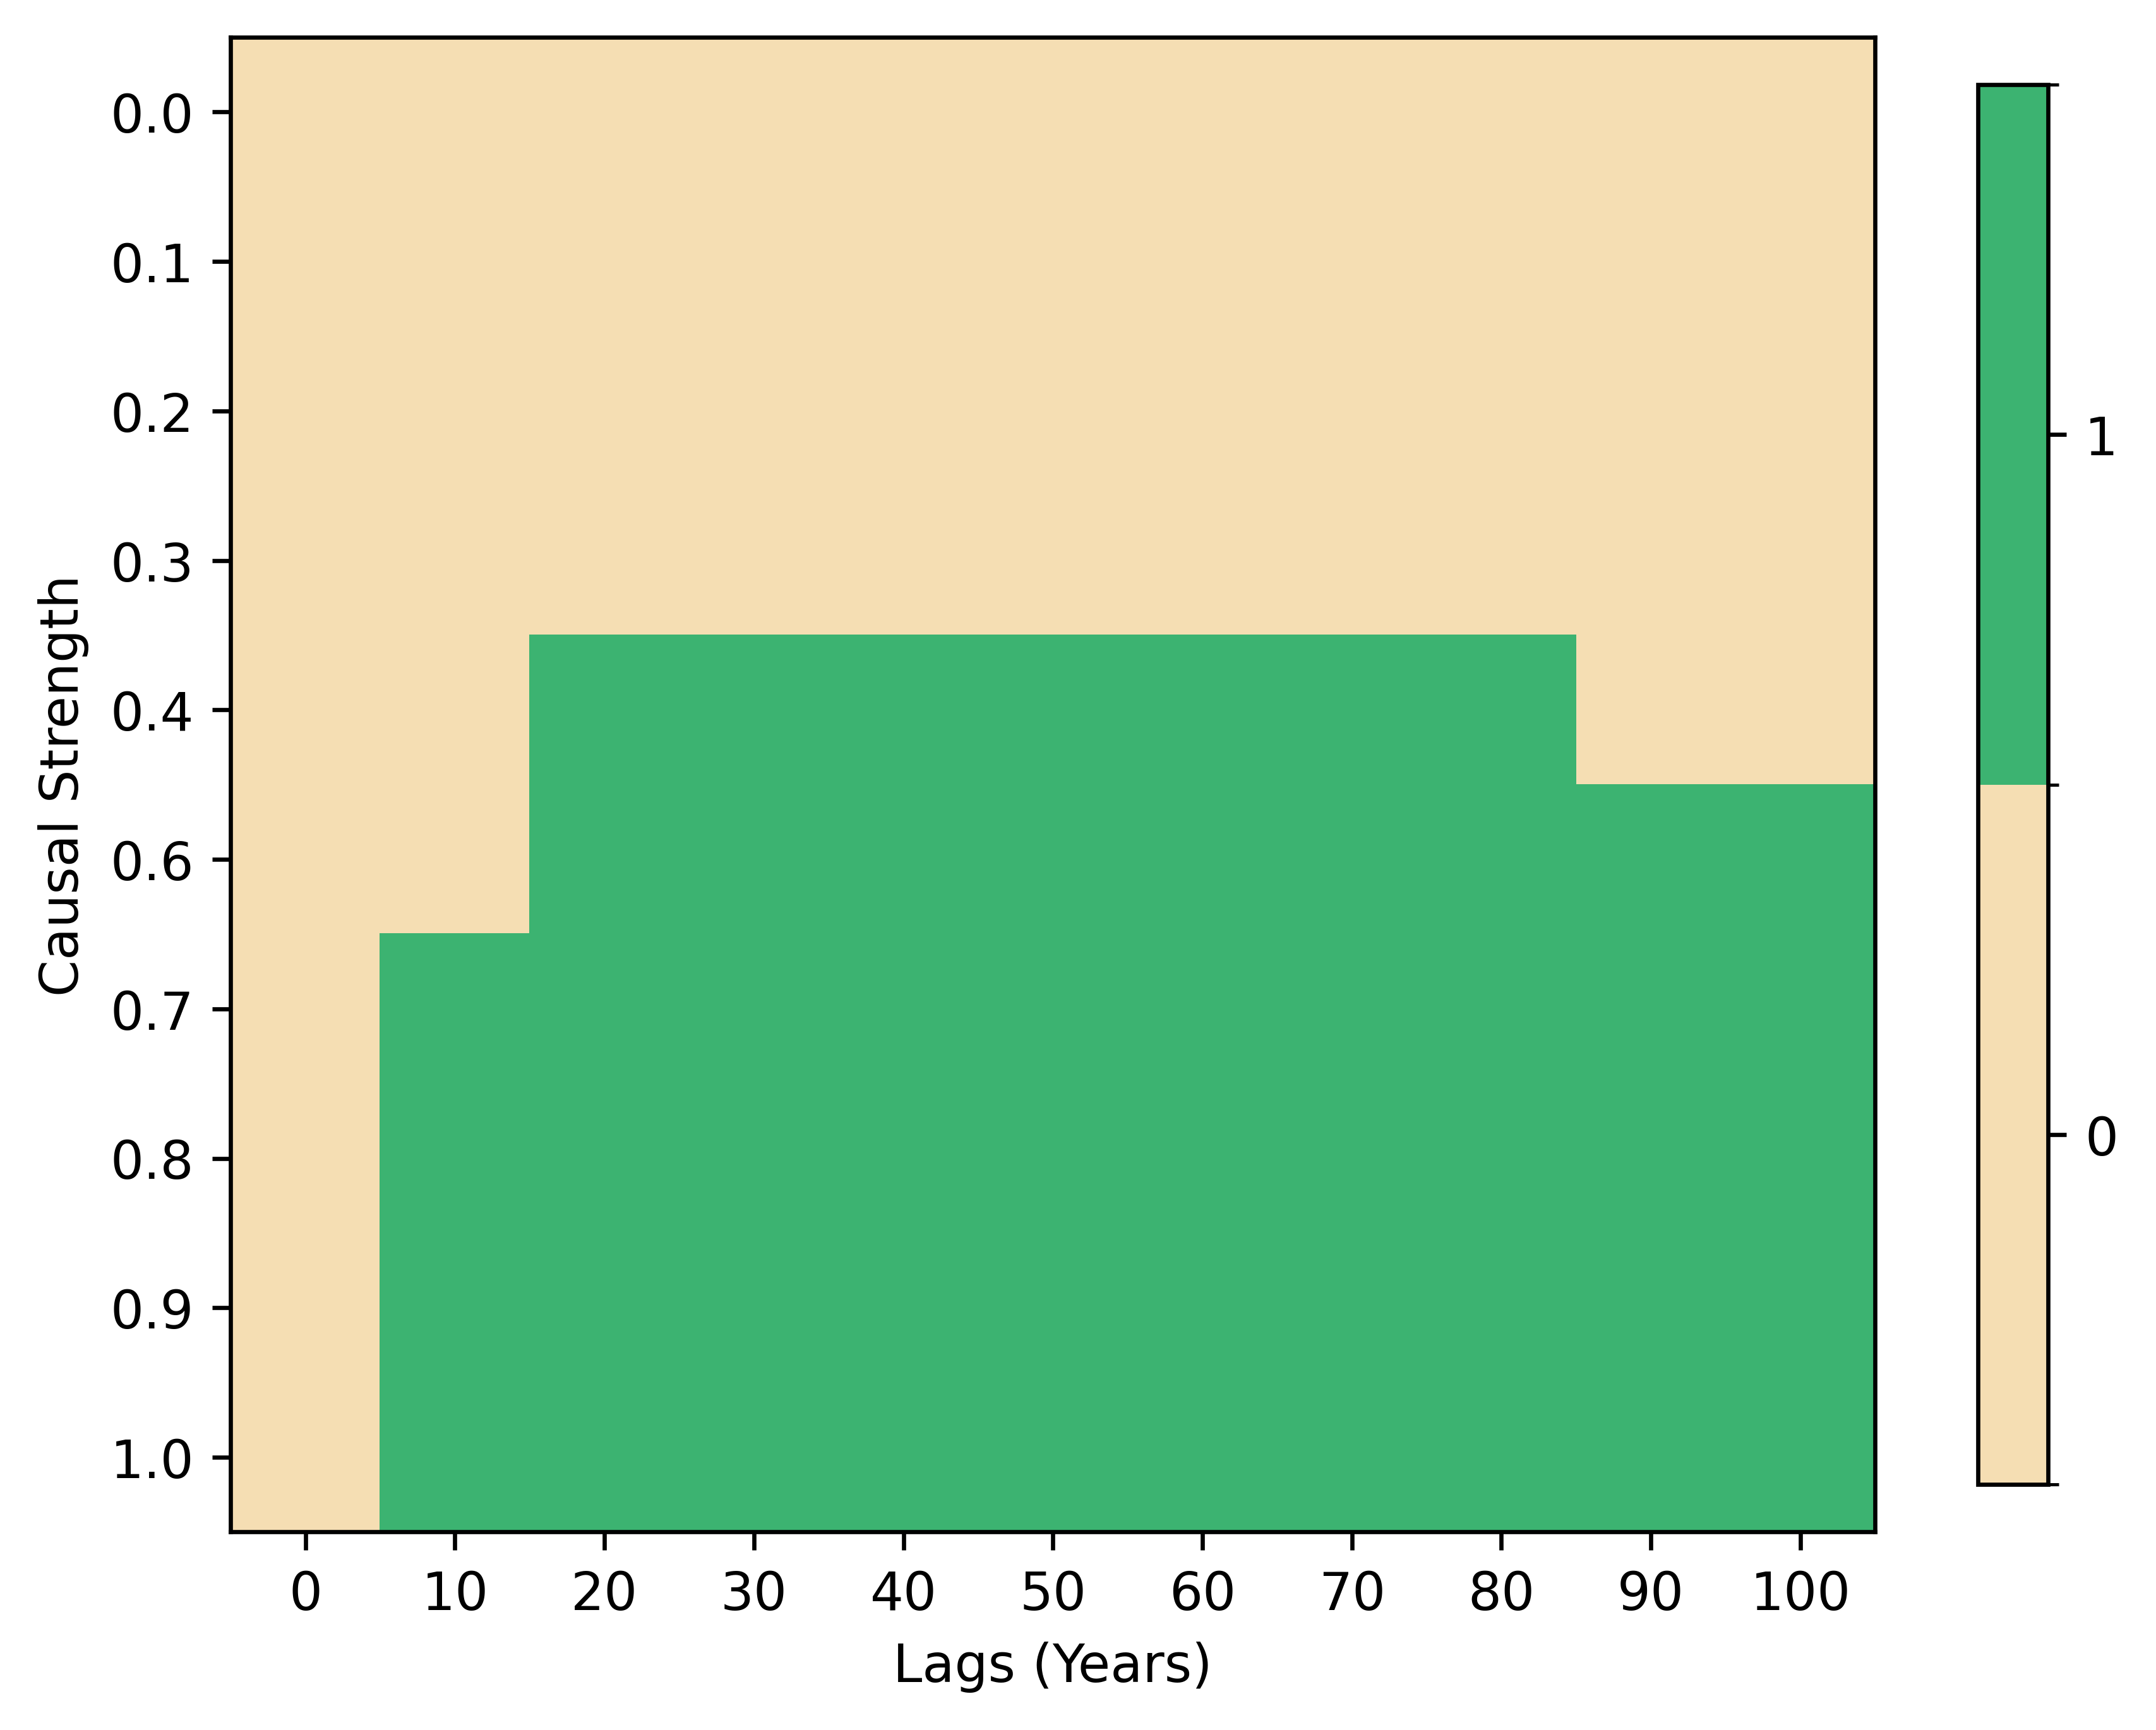

In [84]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors



# 3. Modify the plot according to the new requirements
fig, ax = plt.subplots(figsize=(7, 6), dpi=600)
# Use a discrete colormap with two colors
cmap = colors.ListedColormap(['wheat', 'mediumseagreen'])  # Red for 0, Green for 1
bounds = [-0.5, 0.5, 1.5]
norm = colors.BoundaryNorm(bounds, cmap.N)

# Plot with the specified colormap and norm
cax = ax.matshow(causal_results, interpolation='nearest', cmap=cmap, norm=norm)
# fig.colorbar(cax, ticks=[0, 1], aspect=5)  # Show ticks for 0 and 1 values in colorbar
# add colorbar and set the width
cbar = fig.colorbar(cax, ticks=[0, 1], shrink=0.8)
# ax.set_title('Causal Results')

# Adjust x-ticks and y-ticks as per the new requirements
lags = np.arange(causal_results.shape[1]) * 10  # Multiply by 10
causal_strengths = np.linspace(0, 1, causal_results.shape[0])

ax.set_xticks(np.arange(len(lags)))
ax.set_xticklabels(lags)
ax.set_yticks(np.arange(len(causal_strengths)))
ax.set_yticklabels(np.round(causal_strengths, 1))
ax.set_xlabel('Lags (Years)')
ax.set_ylabel('Causal Strength')

# Move x-ticks to the bottom
ax.xaxis.set_ticks_position('bottom')

plt.show()


In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from toolbox import GC_functions as GC  # Assuming GC_functions is your custom module

# Initialize parameters
causal_strengths = np.arange(0.1, 1.1, 0.1)  # From 0.1 to 1.0 in steps of 0.1
lags = range(11)  # From 0 to 10
iterations = 100
causal_AB_results = np.zeros((len(causal_strengths), len(lags)))
causal_BA_results = np.zeros((len(causal_strengths), len(lags)))

# Loop through combinations of causal strengths and lags
for i, strength in enumerate(causal_strengths):
    for j, lag in enumerate(lags):
        causal_AB_true_count = 0
        causal_BA_true_count = 0
        
        for _ in range(iterations):
            # Generate dummy data and linked data
            dummy_data = gen_dummy_DO(length=1500, delta=10.0, t0=800.0, dt=56.32925780771254, dy=1.0, GS_slope=0.00016431508734689263, GIS_slope=-0.0009404944834246113, sigma=0.06633234778696487, tau=13.649751415738818)
            dummy_warming_lagged = gen_linked_data(dummy_data, causal_strength=strength, delta=10.0, lag=lag, tau=13.649751415738818, sigma=0.06633234778696487)
            
            df_gc = dummy_warming_lagged[['A', 'B']]
            
            df_gc_checked = GC.make_stationary(df_gc,['A', 'B'], test_method='ADF', plot=False)
            # gc_results_A_B = GC.gc4vars(df_gc_checked, max_lags=19, print_results=False)
            causal_AB, causal_BA = gc_test_single_pair(df_gc['A'].values, df_gc['B'].values,max_lags=19)
            
            if causal_AB:
                causal_AB_true_count += 1
            if causal_BA:
                causal_BA_true_count += 1
        
        # Calculate the percentages
        causal_AB_results[i, j] = causal_AB_true_count / iterations
        causal_BA_results[i, j] = causal_BA_true_count / iterations

        causal_AB_results[i, j]  = causal_AB_results[i, j]  >= 0.95
        causal_BA_results[i, j] = causal_BA_results[i, j] >= 0.95


causal_results = np.where((causal_AB_results == 1) & (causal_BA_results == 0), 1, 0)

d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
d:\Users\User\anaconda3\envs\pz_venv_cau

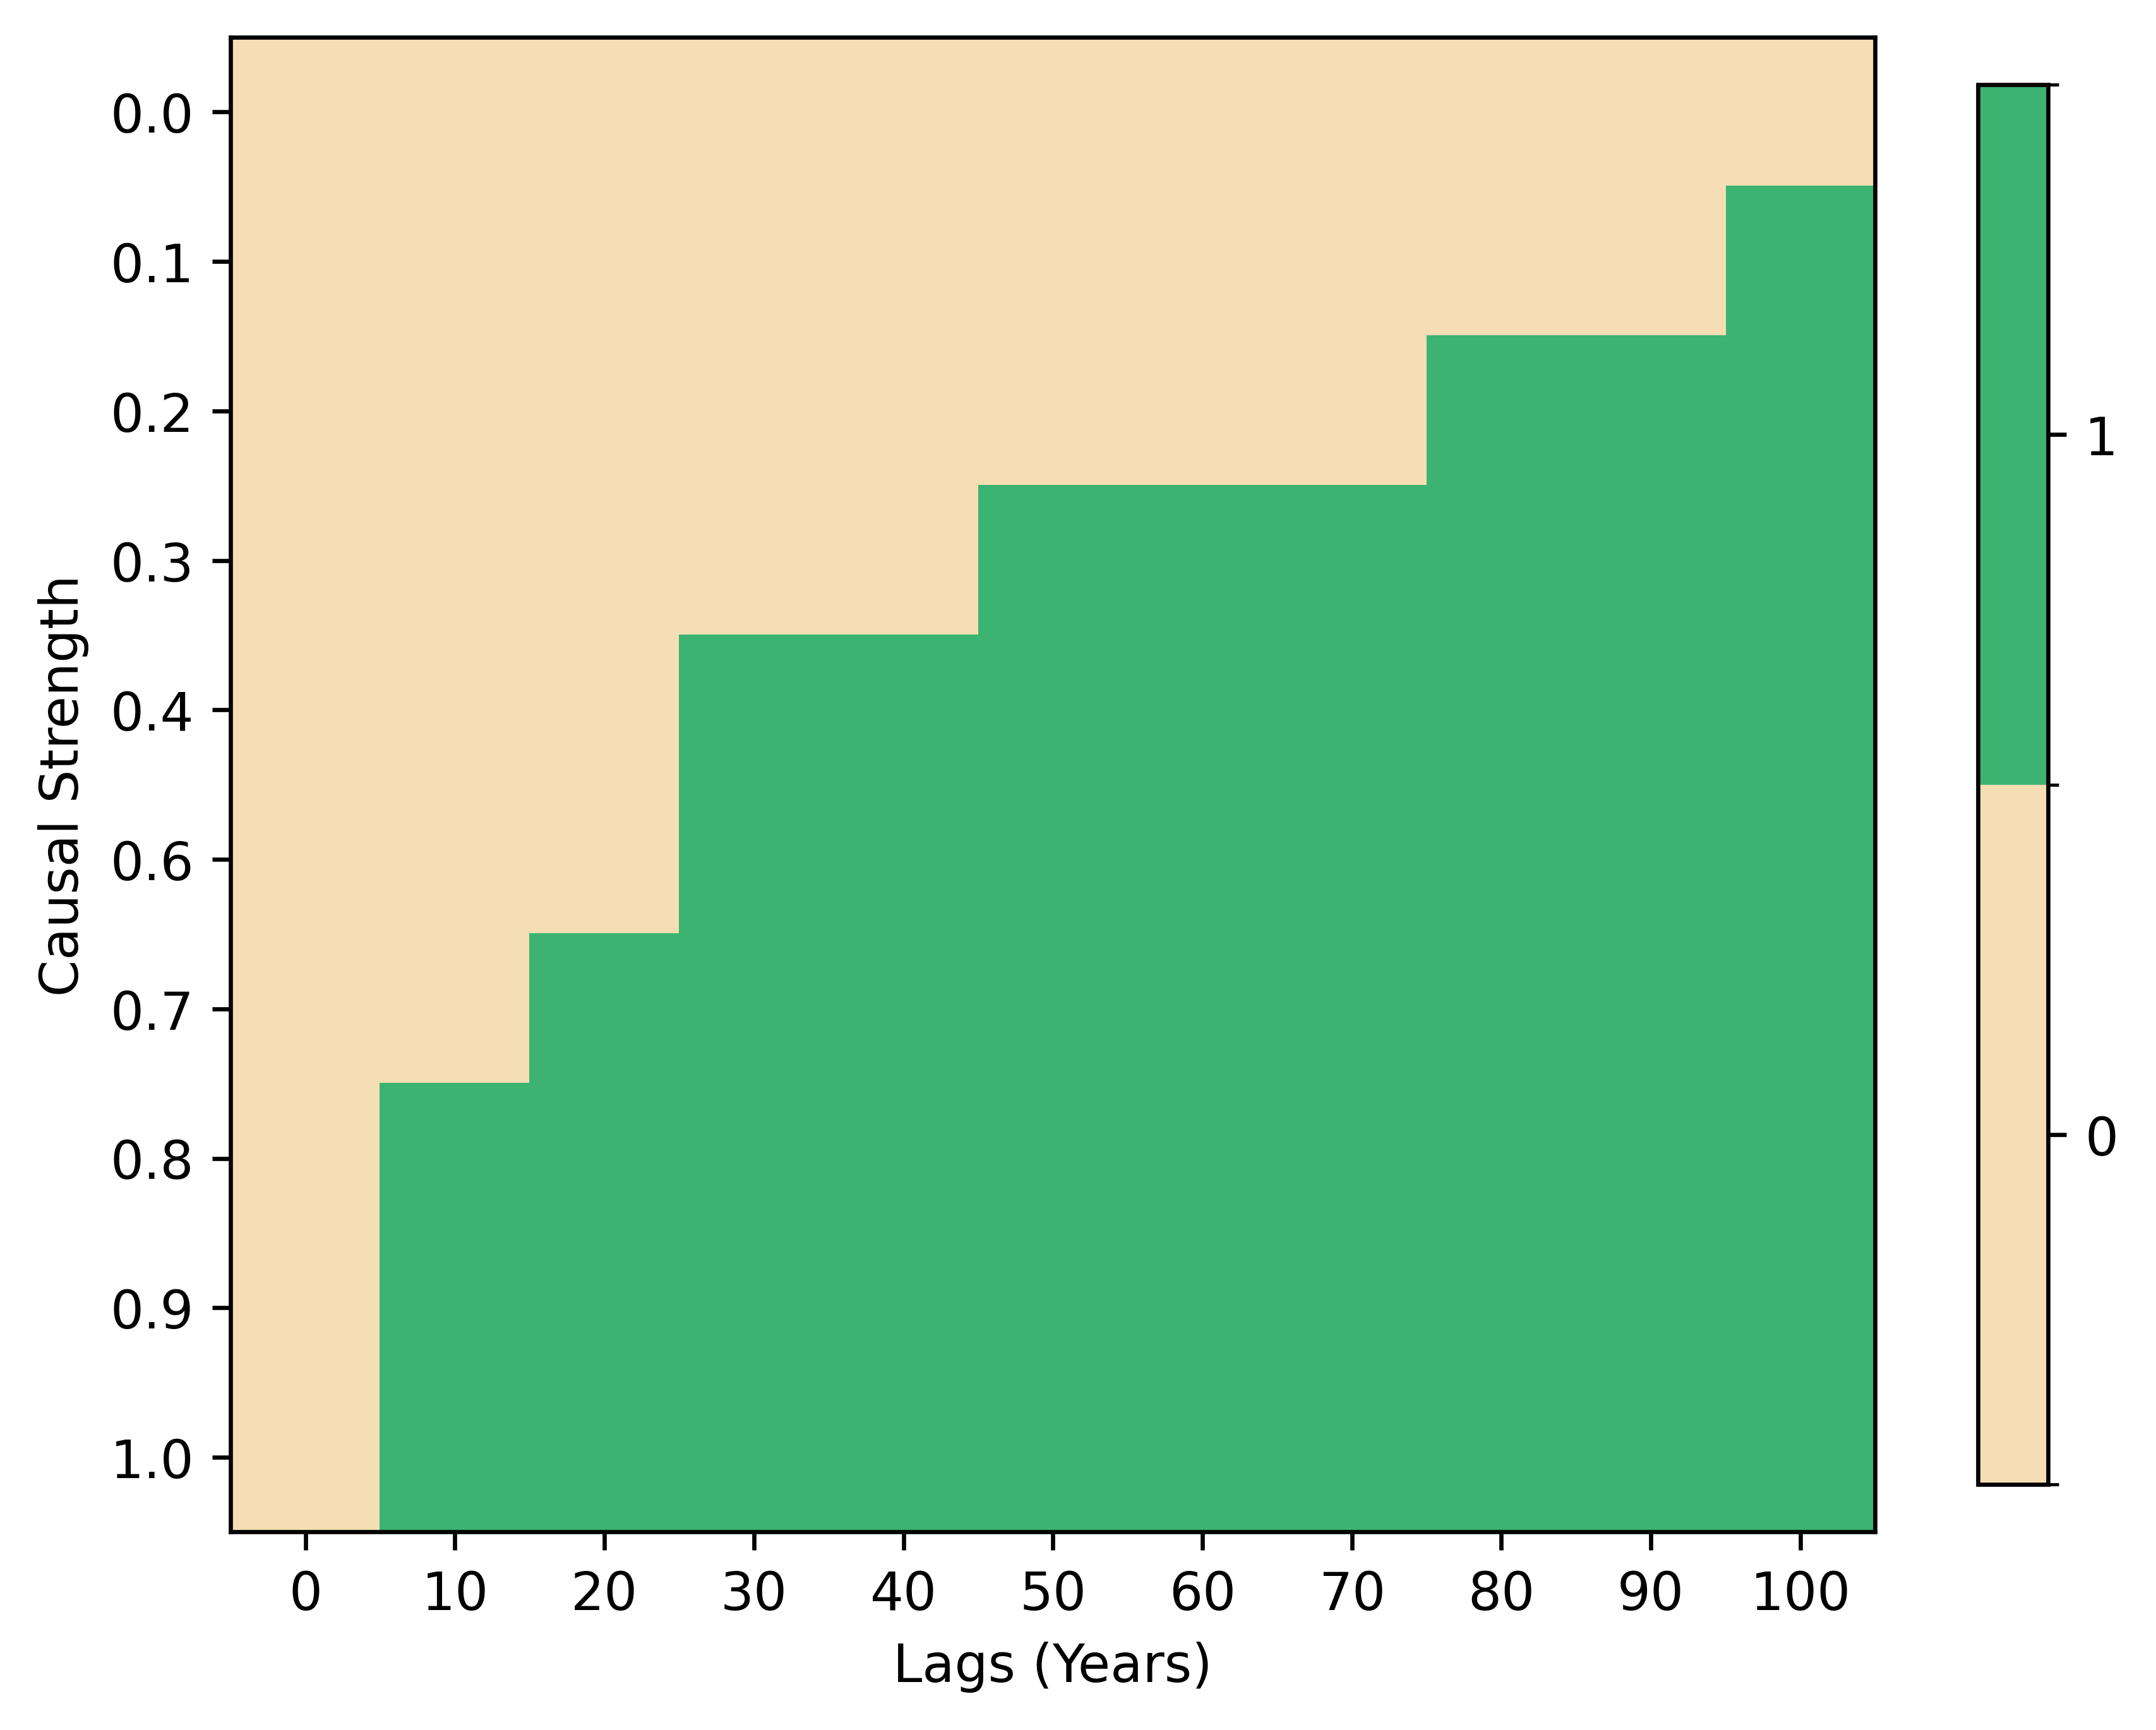

In [77]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors



# 3. Modify the plot according to the new requirements
fig, ax = plt.subplots(figsize=(7, 6), dpi=600)
# Use a discrete colormap with two colors
cmap = colors.ListedColormap(['wheat', 'mediumseagreen'])  # Red for 0, Green for 1
bounds = [-0.5, 0.5, 1.5]
norm = colors.BoundaryNorm(bounds, cmap.N)

# Plot with the specified colormap and norm
cax = ax.matshow(causal_results, interpolation='nearest', cmap=cmap, norm=norm)
# fig.colorbar(cax, ticks=[0, 1], aspect=5)  # Show ticks for 0 and 1 values in colorbar
# add colorbar and set the width
cbar = fig.colorbar(cax, ticks=[0, 1], shrink=0.8)
# ax.set_title('Causal Results')

# Adjust x-ticks and y-ticks as per the new requirements
lags = np.arange(causal_results.shape[1]) * 10  # Multiply by 10
causal_strengths = np.linspace(0, 1, causal_results.shape[0])

ax.set_xticks(np.arange(len(lags)))
ax.set_xticklabels(lags)
ax.set_yticks(np.arange(len(causal_strengths)))
ax.set_yticklabels(np.round(causal_strengths, 1))
ax.set_xlabel('Lags (Years)')
ax.set_ylabel('Causal Strength')

# Move x-ticks to the bottom
ax.xaxis.set_ticks_position('bottom')

plt.show()


# dataframe version

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from toolbox import GC_functions as GC  # Assuming GC_functions is your custom module

# Initialize parameters
causal_strengths = np.arange(0.1, 1.1, 0.1)  # From 0.1 to 1.0 in steps of 0.1
lags = range(11)  # From 0 to 10
iterations = 100
causal_AB_results = np.zeros((len(causal_strengths), len(lags)))
causal_BA_results = np.zeros((len(causal_strengths), len(lags)))

# Loop through combinations of causal strengths and lags
for i, strength in enumerate(causal_strengths):
    for j, lag in enumerate(lags):
        causal_AB_true_count = 0
        causal_BA_true_count = 0
        
        for _ in range(iterations):
            # Generate dummy data and linked data
            dummy_data = gen_dummy_DO(length=1500, delta=10.0, t0=800.0, dt=56.32925780771254, dy=1.0, GS_slope=0.00016431508734689263, GIS_slope=-0.0009404944834246113, sigma=0.06633234778696487, tau=13.649751415738818)
            dummy_warming_lagged = gen_linked_data(dummy_data, causal_strength=strength, delta=10.0, lag=lag, tau=13.649751415738818, sigma=0.06633234778696487)
            
            df_gc = dummy_warming_lagged[['A', 'B']]
            
            df_gc_checked = GC.make_stationary(df_gc,['A', 'B'], test_method='ADF', plot=False)
            gc_results_A_B = GC.gc4vars(df_gc_checked, max_lags=19, print_results=False)
            causal_AB = gc_results_A_B[0]['XY']
            causal_BA = gc_results_A_B[0]['YX']
            
            if causal_AB:
                causal_AB_true_count += 1
            if causal_BA:
                causal_BA_true_count += 1
        
        # Calculate the percentages
        causal_AB_results[i, j] = causal_AB_true_count / iterations
        causal_BA_results[i, j] = causal_BA_true_count / iterations

        causal_AB_results[i, j]  = causal_AB_results[i, j]  >= 0.95
        causal_BA_results[i, j] = causal_BA_results[i, j] >= 0.95


causal_results = np.where((causal_AB_results == 1) & (causal_BA_results == 0), 1, 0)

d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
d:\Users\User\anaconda3\envs\pz_venv_cau

In [42]:

# 2. Save the `causal_results` as a .npy file
np.save('causal_results_syn.npy', causal_results)

In [43]:
# read the file
causal_results = np.load('causal_results_syn.npy')

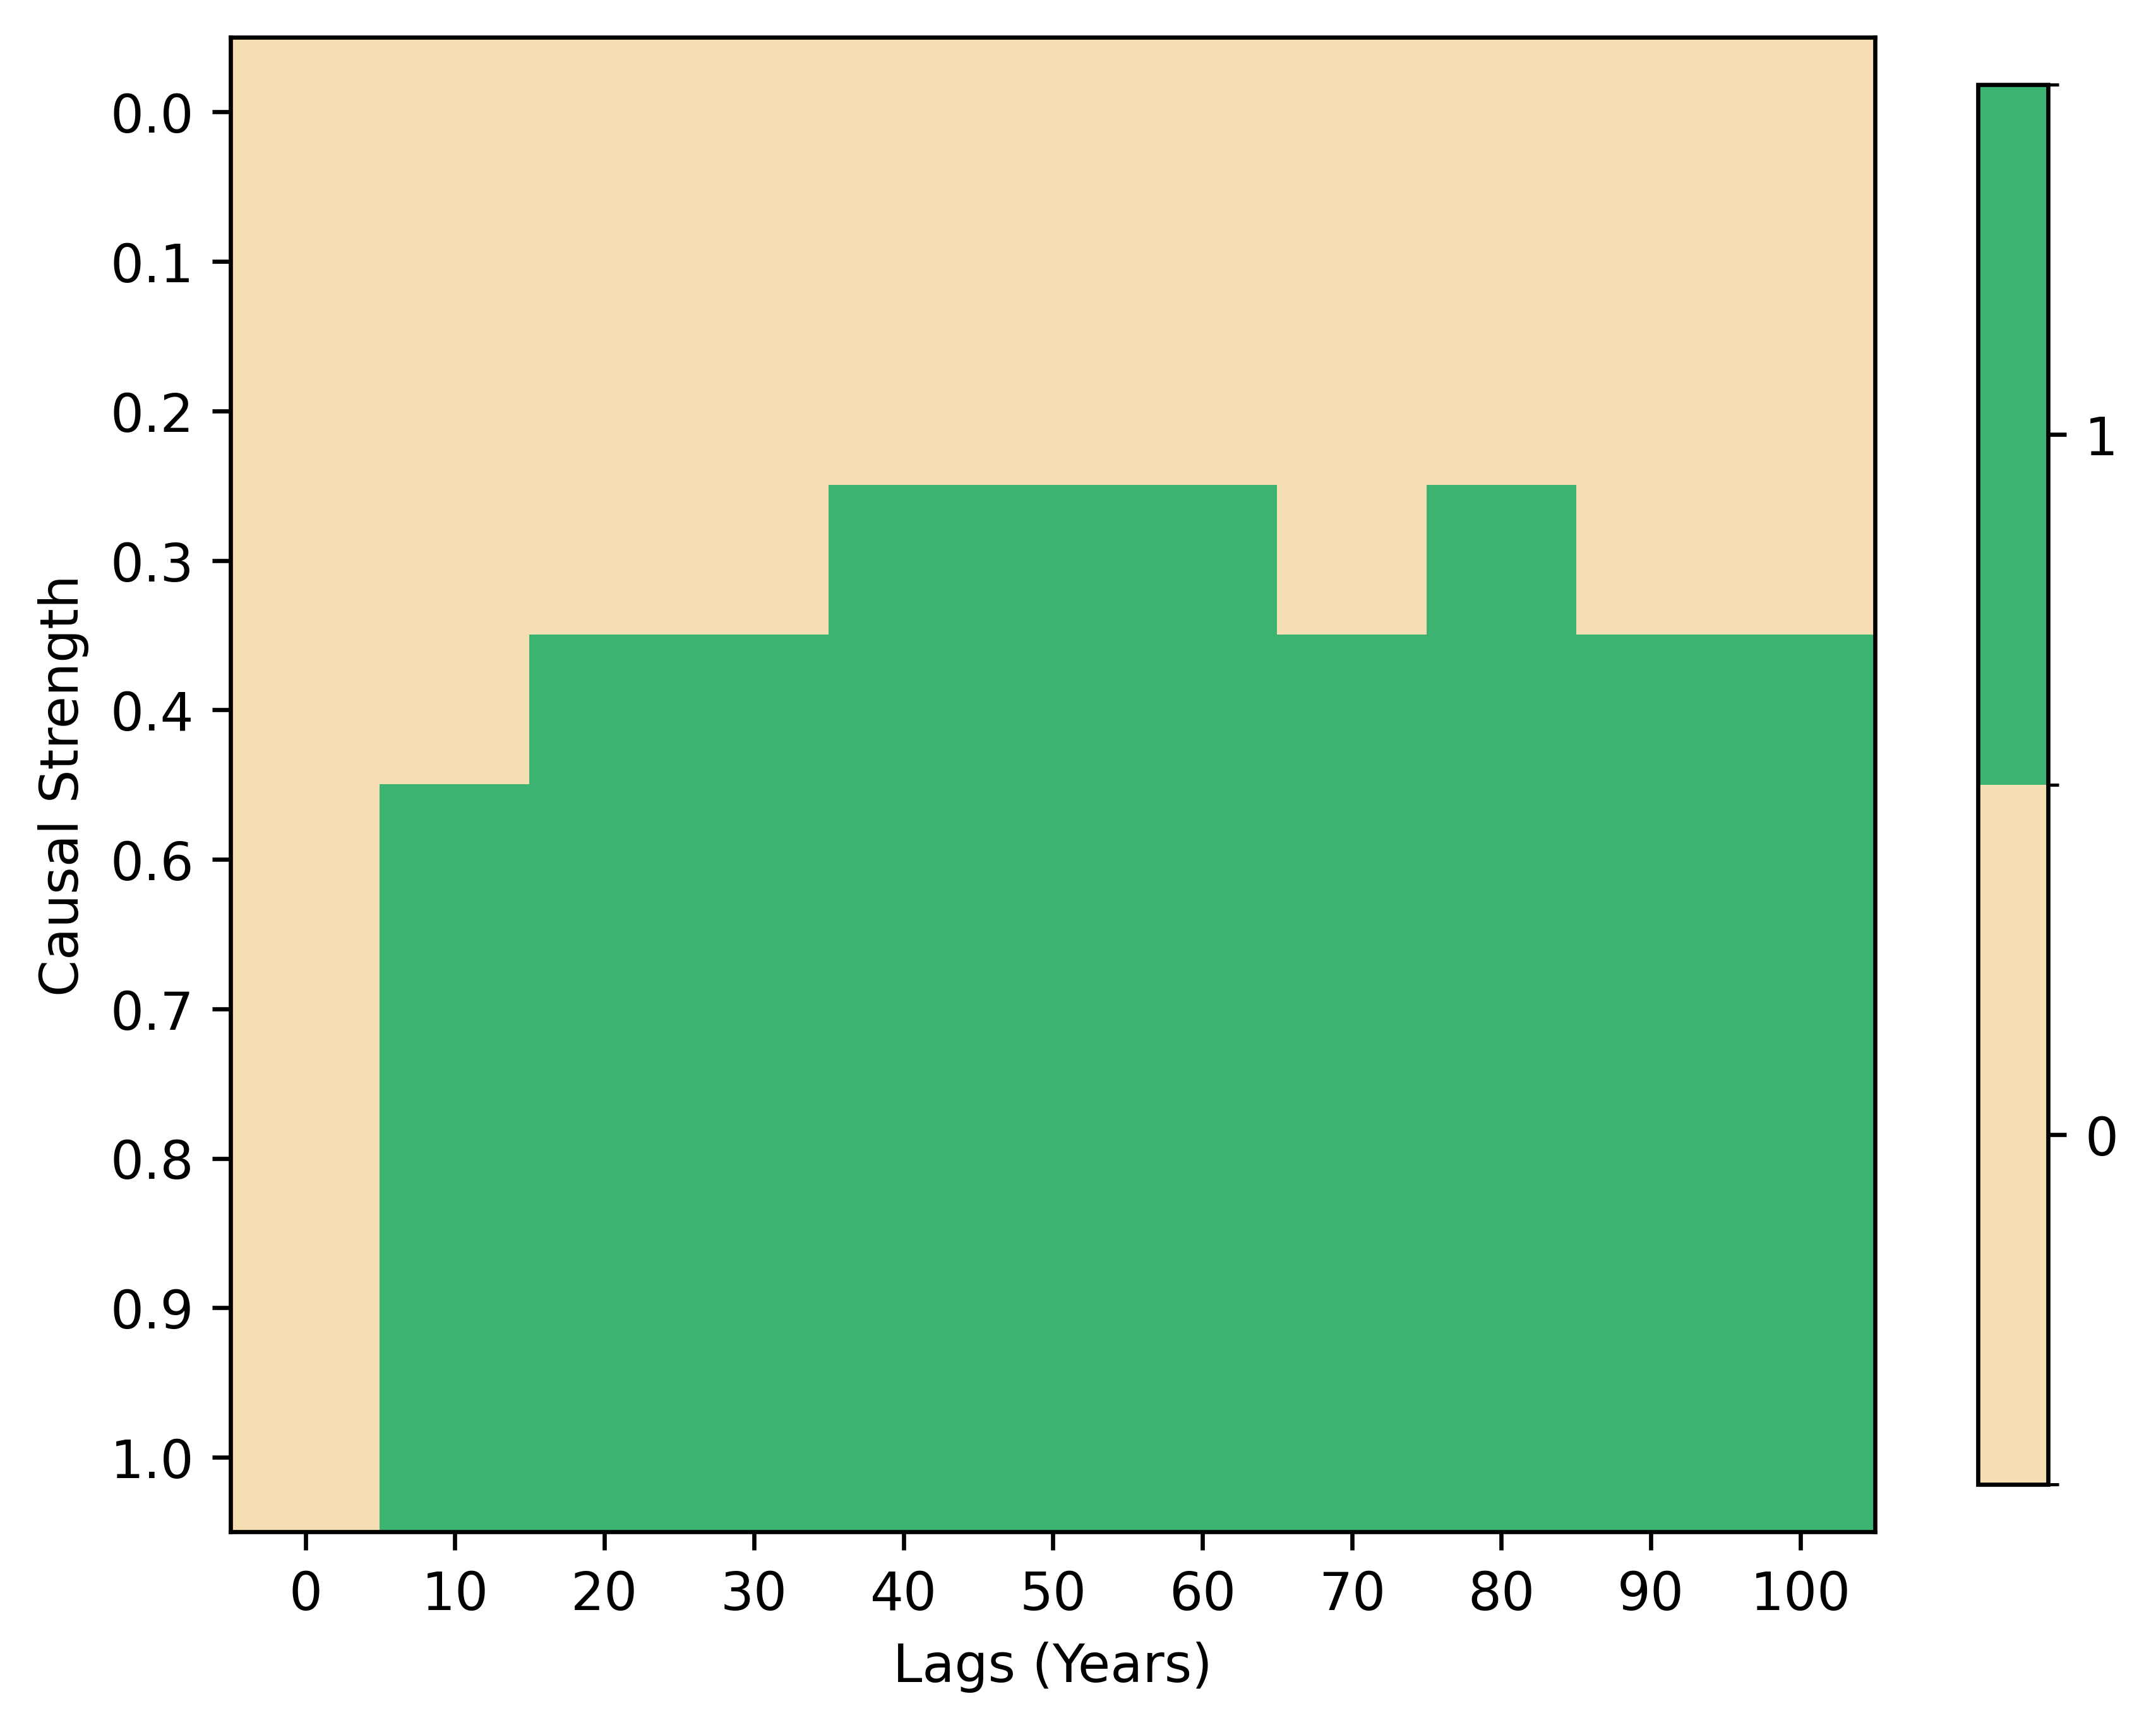

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors



# 3. Modify the plot according to the new requirements
fig, ax = plt.subplots(figsize=(7, 6), dpi=600)
# Use a discrete colormap with two colors
cmap = colors.ListedColormap(['wheat', 'mediumseagreen'])  # Red for 0, Green for 1
bounds = [-0.5, 0.5, 1.5]
norm = colors.BoundaryNorm(bounds, cmap.N)

# Plot with the specified colormap and norm
cax = ax.matshow(causal_results, interpolation='nearest', cmap=cmap, norm=norm)
# fig.colorbar(cax, ticks=[0, 1], aspect=5)  # Show ticks for 0 and 1 values in colorbar
# add colorbar and set the width
cbar = fig.colorbar(cax, ticks=[0, 1], shrink=0.8)
# ax.set_title('Causal Results')

# Adjust x-ticks and y-ticks as per the new requirements
lags = np.arange(causal_results.shape[1]) * 10  # Multiply by 10
causal_strengths = np.linspace(0, 1, causal_results.shape[0])

ax.set_xticks(np.arange(len(lags)))
ax.set_xticklabels(lags)
ax.set_yticks(np.arange(len(causal_strengths)))
ax.set_yticklabels(np.round(causal_strengths, 1))
ax.set_xlabel('Lags (Years)')
ax.set_ylabel('Causal Strength')

# Move x-ticks to the bottom
ax.xaxis.set_ticks_position('bottom')

plt.show()


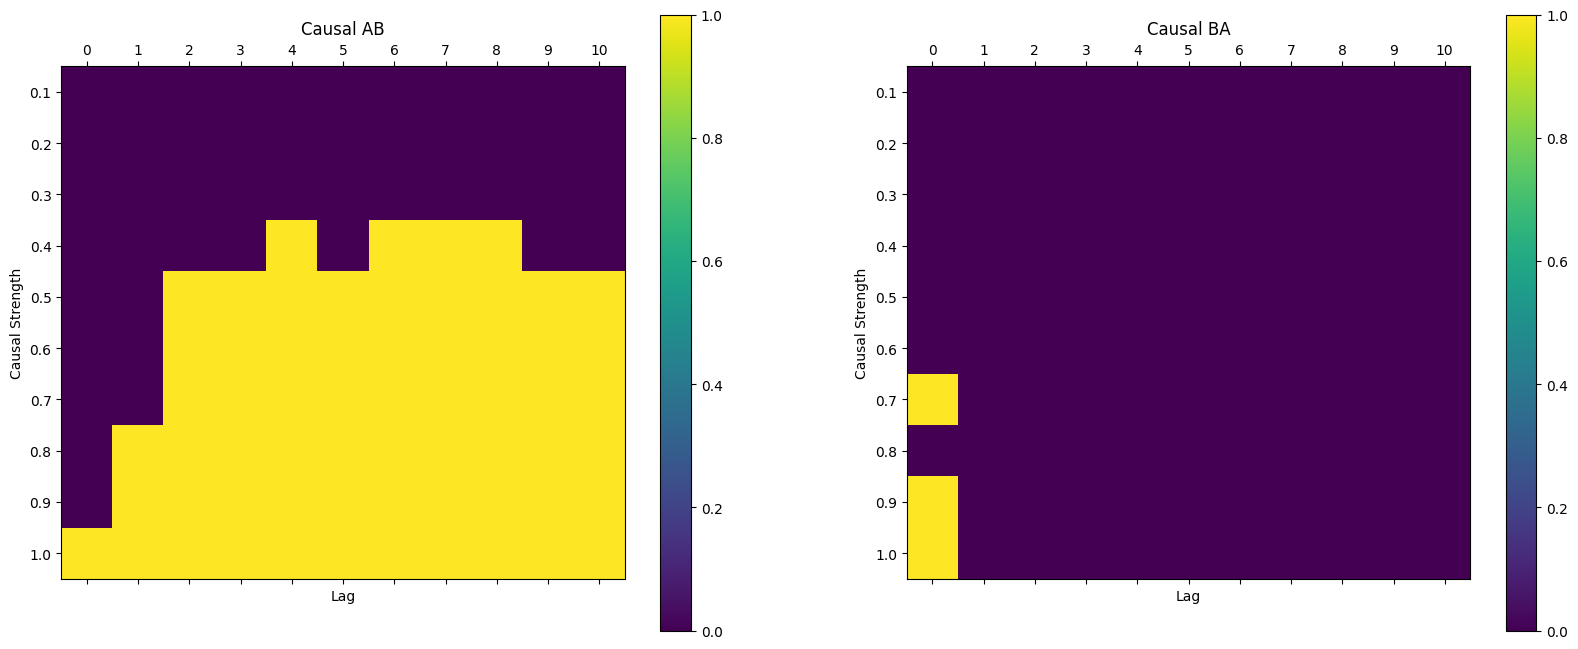

In [40]:
# Plotting the heatmaps
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

# Causal_AB heatmap
cax1 = ax[0].matshow(causal_AB_results, interpolation='nearest', cmap='viridis')
fig.colorbar(cax1, ax=ax[0])
ax[0].set_title('Causal AB')
ax[0].set_xticks(np.arange(len(lags)))
ax[0].set_xticklabels(lags)
ax[0].set_yticks(np.arange(len(causal_strengths)))
ax[0].set_yticklabels(np.round(causal_strengths, 1))
ax[0].set_xlabel('Lag')
ax[0].set_ylabel('Causal Strength')

# Causal_BA heatmap
cax2 = ax[1].matshow(causal_BA_results, interpolation='nearest', cmap='viridis')
fig.colorbar(cax2, ax=ax[1])
ax[1].set_title('Causal BA')
ax[1].set_xticks(np.arange(len(lags)))
ax[1].set_xticklabels(lags)
ax[1].set_yticks(np.arange(len(causal_strengths)))
ax[1].set_yticklabels(np.round(causal_strengths, 1))
ax[1].set_xlabel('Lag')
ax[1].set_ylabel('Causal Strength')

plt.show()

In [41]:
causal_AB_results

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0.],
       [0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

In [24]:
from toolbox import GC_functions as GC  # Assuming GC_functions is your custom module

# Initialize counters for the causality results
causal_AB_true_count = 0
causal_BA_true_count = 0
iterations = 100

for _ in range(iterations):
    # Generate dummy data and linked data
    # dummy_data = gen_dummy_DO(length=1500, delta=10.0, t0=800.0, dt=50.0, dy=2.0, GS_slope=5e-4, GIS_slope=-1e-3, sigma=0.1, tau=1.0)
    # dummy_warming_lagged = gen_linked_data(dummy_data, causal_strength=1, delta=10.0, lag=1, tau=1.0, sigma=0.1)
    dummy_data = gen_dummy_DO(length=1500, delta=10.0, t0=800.0, dt=56.32925780771254, dy=1.0, GS_slope=0.00016431508734689263, GIS_slope=-0.0009404944834246113, sigma=0.06633234778696487, tau=13.649751415738818)
    dummy_warming_lagged = gen_linked_data(dummy_data, causal_strength=1, delta=10.0, lag=1, tau=13.649751415738818, sigma=0.06633234778696487)
    
    # Assuming the GC.make_stationary and GC.gc4vars functions are defined in the GC_functions module
    # Simulate the stationarity check and Granger causality test
    df_gc = dummy_warming_lagged[['A', 'B']]
    
    df_gc_checked = GC.make_stationary(df_gc,['A', 'B'], test_method='ADF', plot=False)
    gc_results_A_B = GC.gc4vars(df_gc_checked, max_lags=19, print_results=False)
    causal_AB = gc_results_A_B[0]['XY']
    causal_BA = gc_results_A_B[0]['YX']
    
    if causal_AB:
        causal_AB_true_count += 1
    if causal_BA:
        causal_BA_true_count += 1

# Calculate the percentages
causal_AB_percentage = causal_AB_true_count / iterations
causal_BA_percentage = causal_BA_true_count / iterations

# Determine the final output based on the 95% threshold
causal_AB_final_result = causal_AB_percentage >= 0.95
causal_BA_final_result = causal_BA_percentage >= 0.95

(causal_AB_final_result, causal_BA_final_result, causal_AB_percentage, causal_BA_percentage)


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
d:\Users\User\anaconda3\envs\pz_venv_cau

(True, False, 1.0, 0.72)